In [1]:
using ModelingToolkit, Sophon, DomainSets
using Optimization, OptimizationOptimJL

@parameters t, x
@variables u(..)
Dt = Differential(t)
Dx = Differential(x)
Dxx = Differential(x)^2

r1 = 0.02
r2 = 1

eq = Dt(u(t, x)) - Dxx(r2*(u(t,x)^3 - u(t,x)) - r1 * Dxx(u(t,x))) ~ 0.0

bcs = [u(0, x) ~ cospi(x)-exp(-4*π*π*abs2(x)),
    u(t, -1.0) ~ u(t, 1.0),
    Dx(u(t, -1.0)) ~ Dx(u(t, 1.0))]

domains = [t ∈ Interval(0.0, 0.25),
    x ∈ Interval(-1.0, 1.0)]

@named pde_system = PDESystem(eq, bcs, domains, [t,x], [u(t,x)])

PDESystem
Equations: Equation[Differential(t)(u(t, x)) - Differential(x)(Differential(x)(u(t, x)^3 - 0.02Differential(x)(Differential(x)(u(t, x))) - u(t, x))) ~ 0.0]
Boundary Conditions: Equation[u(0, x) ~ cospi(x) - exp(-39.47841760435743abs2(x)), u(t, -1.0) ~ u(t, 1.0), Differential(x)(u(t, -1.0)) ~ Differential(x)(u(t, 1.0))]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(t, 0.0..1.0), Symbolics.VarDomainPairing(x, -1.0..1.0)]
Dependent Variables: Num[u(t, x)]
Independent Variables: Num[t, x]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

In [2]:
chain = FullyConnected(2, 1, tanh; hidden_dims=16, num_layers=5)
pinn = PINN(chain)
sampler = QuasiRandomSampler(1000, (400, 100, 100))
strategy = NonAdaptiveTraining(1, (100,10,10))
prob = Sophon.discretize(pde_system, pinn, sampler, strategy)

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(layer_1 = (weight = [-1.4685754776000977 -0.2959884703159332; -1.8868504762649536 0.24390068650245667; … ; -1.4172738790512085 0.9068280458450317; 0.32627272605895996 0.9405515789985657], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [0.10830365121364594 0.2413652241230011 … -0.37911999225616455 0.5206612944602966; -0.29793721437454224 -0.10148467868566513 … 0.08753013610839844 0.4715240001678467; … ; 0.6884480714797974 0.3293430507183075 … -0.3331504166126251 -0.21810580790042877; 0.5754575729370117 0.16981111466884613 … -0.36848610639572144 -0.21387381851673126], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = [0.6798692345619202 -0.3398451507091522 … 0.38751962780952454 -0.29678764939308167; -0.06342615187168121 0.6426460146903992 … -0.48465532064437866 -0.28906044363975525; … ; -0.01843336410820484 -0.6776251792907715 … 0.22416873276233673 0.22004032135009766; -0.07910443097352982 -0.2913879454135895

In [3]:
i = 0
function callback(p, l)
    global i
    i%100==0 && println("Loss: $l")
    i += 1
    return false
end

res = Optimization.solve(prob, BFGS(); maxiters=1000, callback=callback)

Loss: 46847.286033749086


Loss: 3.150449618044628


Loss: 1.069006297064343


Loss: 0.8710055459218716


Loss: 0.775602436623417


Loss: 0.6834513801953834


Loss: 0.5280728066165413


Loss: 0.3346827291418555


Loss: 0.19086461182121817


Loss: 0.07909223810053637


Loss: 0.037499879430864795


u: ComponentVector{Float64}(layer_1 = (weight = [-2.1746515416542564 -1.9863358245681046; -1.9786708303511857 0.5313560862249368; … ; -1.7661311803173143 -0.03753063738130951; 5.342414992016016 1.8998676018827527], bias = [-4.1769070930521535; 1.2282665265922952; … ; -4.828803480140824; 3.1143053496197566;;]), layer_2 = (weight = [3.5617149501631786 0.96435081826349 … -0.812014769639996 0.14770281028060667; -1.014842018001853 0.02055391385209709 … 0.148545452280366 1.5274324293079362; … ; 1.0664171488960785 1.1619055774454037 … 0.4979231287950495 -0.05484205903863845; 0.2781955170069958 -1.6191081212708136 … -0.6703736288188948 -2.1819253930790374], bias = [0.6682601249918639; 2.7901702419699834; … ; -1.8602967189119721; 1.5520451857762518;;]), layer_3 = (weight = [1.3450838512076781 -0.1003151409263349 … 0.10022461161567447 0.0017231554137546808; 1.0161044126099181 0.6702979943608505 … -0.8082493619856329 1.0027423241786866; … ; 0.7236445649305109 0.028236253800318557 … -1.08415684380

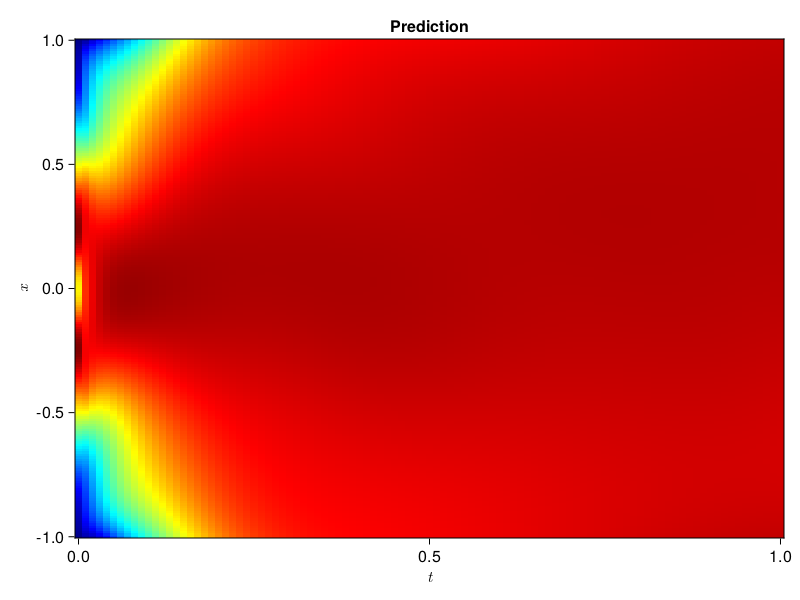

In [4]:
using CairoMakie, MakiePublication

phi = pinn.phi
ts, xs = [infimum(d.domain):0.01:supremum(d.domain) for d in pde_system.domain]
axis = (xlabel=L"t", ylabel=L"x", title="Prediction")
u_pred = [sum(pinn.phi([t, x], res.u)) for t in ts, x in xs]
heatmap(ts, xs, u_pred, axis=axis, colormap=:jet)

In [5]:
for tmax in [0.5, 0.75, 1.0]
    pde_system.domain[1] = t ∈ 0.0..tmax
    data = Sophon.sample(pde_system, sampler)
    prob = remake(prob; u0=res.u, p=data)
    res = Optimization.solve(prob, BFGS(); maxiters=1000, callback=callback)
    u_pred = [sum(pinn.phi([t, x], res.u)) for t in ts, x in xs]
    fig, ax, hm = heatmap(ts, xs, u_pred, axis=axis, colormap=:jet)
    display(fig)
end


Loss: 59.26598182902062


InterruptException: Error trying to display an error.

In [6]:
using JLD2
jldsave("cahn-hilliard_finitediff.jld2"; pde=pde_system, pinn=pinn, res=res, prob=prob)

Loss: 0.6842902725954241


# Improve accuracy with taylordiff

In [ ]:
using TaylorDiff
prob = Sophon.discretize(pde_system, pinn, sampler, strategy; derivative=Sophon.taylordiff)
prob = remake(prob; u0=res.u)
i=0
res2 = Optimization.solve(prob, BFGS(); maxiters=1000, callback=callback)

In [ ]:
phi = pinn.phi
ts, xs = [infimum(d.domain):0.01:supremum(d.domain) for d in pde_system.domain]
axis = (xlabel=L"t", ylabel=L"x", title="Prediction")
u_pred = [sum(pinn.phi([t, x], res.u)) for t in ts, x in xs]
heatmap(ts, xs, u_pred, axis=axis, colormap=:jet)

In [ ]:
using JLD2
jldsave("cahn-hilliard_finitediff_taylordiff.jld2"; pde=pde_system, pinn=pinn, res=res2, prob=prob)